In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
# os.environ['USE_PYGEOS'] = '0'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
# import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
synthfirm_all = read_csv('outputs_SF/synthetic_firms.csv')
region_map = gpd.read_file('inputs_SF/SFBay_freight.geojson')
mesozone_id_lookup = read_csv('inputs_SF/zonal_id_lookup_final.csv')

lehd_validation = read_csv('inputs_SF/LEHD_employment.csv')
synthfirm_output = read_csv('outputs_SF/processed_b2b_flow_summary_mesozone.csv')
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859..."
1,060510001011,6051,4047.0,"MULTIPOLYGON (((-118.94774 37.77604, -118.9459..."
2,060930002001,6093,8981.0,"MULTIPOLYGON (((-122.25152 41.75726, -122.2491..."
3,060570009003,6057,4462.0,"MULTIPOLYGON (((-120.85050 39.39899, -120.8491..."
4,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119..."


In [3]:
# calculate land area
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 
# sf_map.loc[:, "area"] = sf_map.area/ 10**6 # km^2
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303301
1,060510001011,6051,4047.0,"MULTIPOLYGON (((-118.94774 37.77604, -118.9459...",2977.820172
2,060930002001,6093,8981.0,"MULTIPOLYGON (((-122.25152 41.75726, -122.2491...",1372.741273
3,060570009003,6057,4462.0,"MULTIPOLYGON (((-120.85050 39.39899, -120.8491...",1032.657641
4,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092172


In [4]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count          8.390414e+06
employment_count    1.075726e+08
dtype: float64


In [5]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, 
                        on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,employment_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,30,4498.258503,5072,60014001001,6001,64,San Francisco
1,2,34,255.635178,9148,60014002001,6001,64,San Francisco
2,3,48,351.784439,1029,60014002002,6001,64,San Francisco
3,4,34,975.381942,10526,60014003001,6001,64,San Francisco
4,5,32,343.366513,8963,60014003002,6001,64,San Francisco


In [6]:
firm_in_study_area = \
firm_by_zone.loc[firm_by_zone['FAFID'].isin([62, 64, 65, 69])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

421169
5827560.989253243
410
403


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
123,6101,62,1,1111A0,3,1.000000,124,10044
124,6011,69,1,1111A0,3,1.000000,125,1313
1043,6067,62,1,1111A0,3,1.000000,1044,5509
1044,6113,62,1,1111A0,3,4.666667,1045,10462
1045,6113,62,1,1111A0,3,4.666667,1046,10451


5827560.989253243
25006.1 0.98


,County,LEHD employment,CBPZONE,SynthFirm employment
0,6001,613088.50,6001,653594.002016
1,6003,147.50,6003,44.000001
2,6005,6257.75,6005,5091.999933
3,6007,56102.75,6007,54320.000567
4,6009,5620.75,6009,5402.999965


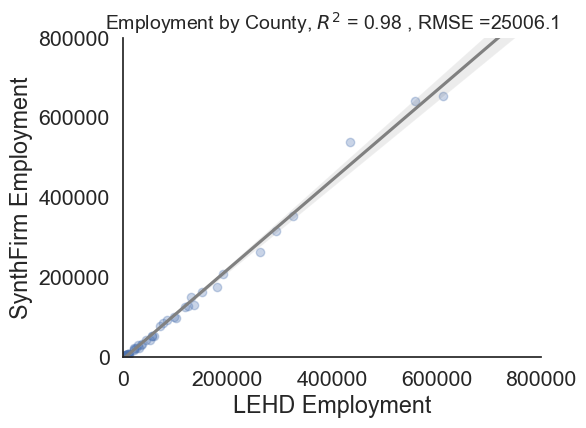

In [7]:
# compare to LEHD data
#lehd_validation.head(5)
lehd_firm_by_county = lehd_validation.loc[lehd_validation['industry'] == '0']
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
# print(firm_in_study_area_by_county.head(5))

lehd_firm_by_county = lehd_firm_by_county.groupby('geography')[['EmpS']].mean()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     left_on = 'geography',
                                     right_on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'CBPZONE', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_county['LEHD employment'], 
                              firm_comparison_by_county['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_county['LEHD employment'], 
                  firm_comparison_by_county['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_county['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('seaborn-v0_8-white')
# plt.rcParams['axes.facecolor'] = 'white'
sns.set(font_scale=1.4)  # crazy big
sns.set_style("white")
g = sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
    scatter_kws = {'alpha':0.3})
# g.set_facecolor("white")

plt.xlim([0, 800000])
plt.ylim([0, 800000])
plt.xlabel('LEHD Employment')
plt.ylabel('SynthFirm Employment')
plt.title('Employment by County, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig('plots_SF/emp_by_county_validation.png', dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_county.head(5)

In [8]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


5425064.5
5827560.989253243


,industry,Emp
0,11,171945.999763
1,21,7701.999979
2,22,2997.000058
3,23,319697.998677
4,31-33,254016.998109
5,42,282088.997724
6,44-45,664395.996405
7,48-49,181587.001846
8,51,303159.004422
9,52,224549.000772


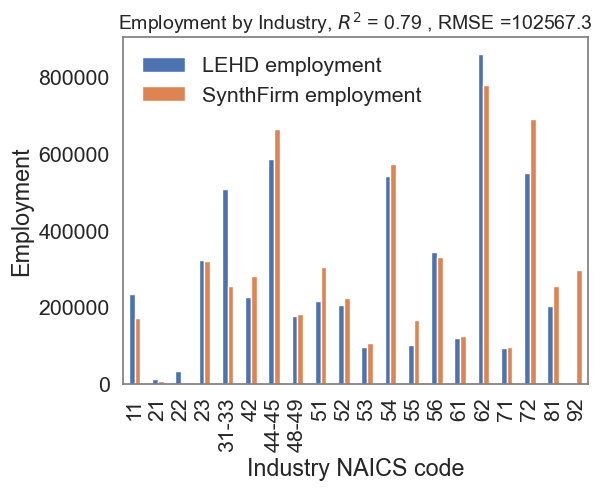

In [8]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = lehd_validation.loc[lehd_validation['industry'] != '0']

# print(lehd_firm_by_industry.industry.unique())

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['geography', 'industry'])[['EmpS']].mean()

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['geography'].isin(selected_counties)]

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['EmpS']].sum()
print(lehd_firm_by_industry['EmpS'].sum())

print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
# print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_industry['LEHD employment'], 
                              firm_comparison_by_industry['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_industry['LEHD employment'], 
                  firm_comparison_by_industry['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)

# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
sns.set(font_scale=1.4)  # crazy big
fig, ax = plt.subplots(figsize = (6,4.5))
ax.set(facecolor = "white")
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry", ax = ax)
plt.xlabel('Industry NAICS code')
plt.ylabel('Employment')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='gray')
# ax.patch.set_edgecolor('black')  

# ax.patch.set_linewidth(1)  
plt.title('Employment by Industry, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig('plots_SF/emp_by_industry_validation.png', dpi = 200, 
            bbox_inches = 'tight')

firm_in_study_area_by_industry

In [9]:
synthfirm_in_study_area.groupby(['industry'])[['Emp]].count()

,Emp
industry,
11,13208
21,481
22,566
23,34552
31-33,14329
42,17863
44-45,47549
48-49,10546
51,8447


In [10]:
firm_in_region = firm_by_zone.loc[firm_by_zone['FAFID'].isin([64])]
region_map_with_firm = region_map.merge(firm_in_region, on='MESOZONE', how='inner')
region_map_with_firm.loc[:, 'firm_per_area'] = \
region_map_with_firm.loc[:, 'firm_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.loc[:, 'emp_per_area'] = \
region_map_with_firm.loc[:, 'employment_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,area,firm_count,employment_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME,firm_per_area,emp_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303301,68,596.351212,0,60411242004,6041,64,San Francisco,29.522851,258.911587
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092172,68,1275.957857,4,60750108001,6075,64,San Francisco,737.752140,13843.244692
2,060014227001,6001,394.0,"MULTIPOLYGON (((-122.24986 37.86749, -122.2484...",0.184157,37,594.606344,7,60014227001,6001,64,San Francisco,200.915988,3228.808680
3,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,66,5034.008539,8,60750611002,6075,64,San Francisco,1203.447930,91790.411459
4,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188181,45,533.376781,9,60855094013,6085,64,San Francisco,239.131022,2834.376323


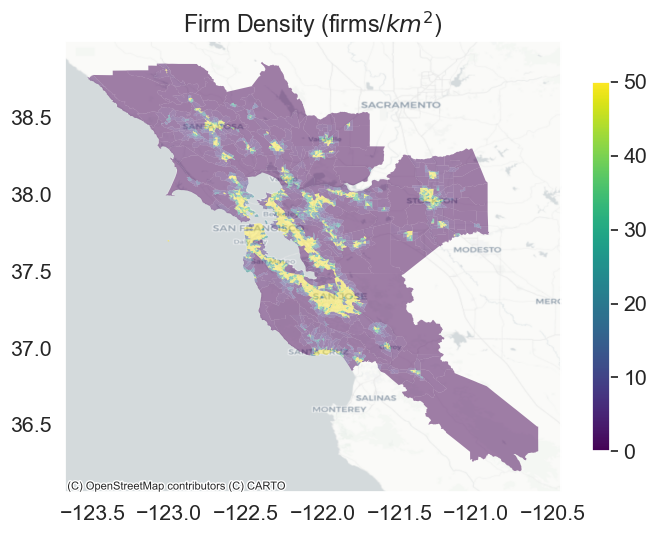

In [25]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'firm_per_area', 
                           vmin=0, vmax=50, alpha = 0.5, legend=True,
                              cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.8}, edgecolor='none')
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.title('Firm Density (firms/$km^{2}$)')
plt.savefig('plots_SF/region_firm_count.png', dpi = 200)

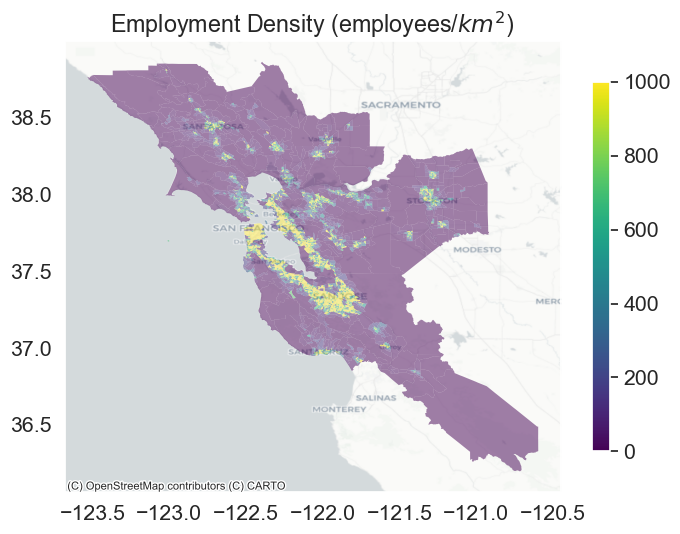

In [26]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'emp_per_area', 
                            vmin=0, vmax=1000, alpha = 0.5, legend=True,
                               cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.8}, edgecolor='none')
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Employment Density (employees/$km^{2}$)')
ax.grid(False)
plt.savefig('plots_SF/region_emp_count.png', dpi = 200)

In [16]:
# plot production
print(synthfirm_output.columns)
production_in_region = synthfirm_output.loc[synthfirm_output['orig_FAFID'].isin([64])]
production_in_region = production_in_region.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})

region_map_with_production = \
region_map.merge(production_in_region, on='MESOZONE', how='inner')
region_map_with_production.loc[:, 'production_per_area'] = \
region_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_production.head(5)

Index(['Unnamed: 0', 'SellerZone', 'orig_FAFID', 'orig_FAFNAME', 'BuyerZone',
       'dest_FAFID', 'dest_FAFNAME', 'SCTG_Group', 'SCTG_Name', 'mode_choice',
       'tmiles', 'ShipmentLoad', 'count', 'outbound', 'inbound', 'Distance'],
      dtype='object')


,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,production_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303301,0.544544,0.214476
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092172,202.444404,1992.522350
2,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,61.589786,1018.797633
3,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188181,1.215518,5.859772
4,060750128004,6075,5737.0,"MULTIPOLYGON (((-122.44730 37.79846, -122.4426...",0.065750,44.106737,608.565978


In [18]:
production_in_region.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
1127,1127,481,Austin,11,Birmingham,4,mfr_goods,For-hire Truck,1.093548e+06,1.274888,291,1,0,857.760000
1128,1128,481,Austin,11,Birmingham,4,mfr_goods,Rail/IMX,2.607898e+04,0.026212,6,1,0,994.940199
1129,1129,481,Austin,12,Mobile,3,interm_food,For-hire Truck,6.561531e+05,0.715551,28,1,0,916.990000
1130,1130,481,Austin,12,Mobile,3,interm_food,Rail/IMX,2.384587e+04,0.025951,1,1,0,918.880514
1131,1131,481,Austin,12,Mobile,4,mfr_goods,For-hire Truck,9.586375e+05,1.045418,211,1,0,916.990000


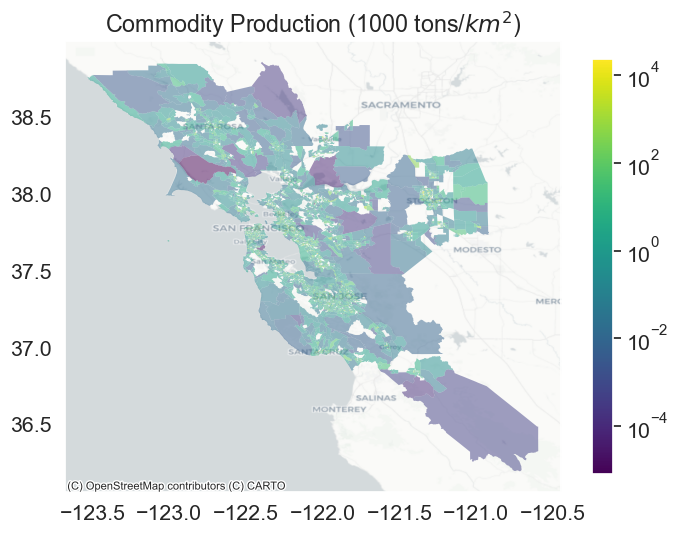

In [27]:
ax = region_map_with_production.plot(figsize = (8,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            norm=matplotlib.colors.LogNorm(vmin=region_map_with_production.production_per_area.min(), 
                                                           vmax=region_map_with_production.production_per_area.max()),
                            cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.9})
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)

ax.grid(False)
plt.title('Commodity Production (1000 tons/$km^{2}$)')
plt.savefig('plots_SF/region_production_allmodes.png', dpi = 200)

In [20]:
# print(synthfirm_output.columns)
attraction_in_region = synthfirm_output.loc[synthfirm_output['dest_FAFID'].isin([64])]
attraction_in_region = attraction_in_region.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})

region_map_with_attraction = \
region_map.merge(attraction_in_region, on='MESOZONE', how='inner')
region_map_with_attraction.loc[:, 'attraction_per_area'] = \
region_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_attraction.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_attraction.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,attraction_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303301,18.524643,7.296173
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092172,253.765728,2497.643187
2,060014227001,6001,394.0,"MULTIPOLYGON (((-122.24986 37.86749, -122.2484...",0.184157,41.300247,203.451681
3,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,151.315946,2503.017735
4,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188181,41.376856,199.469617


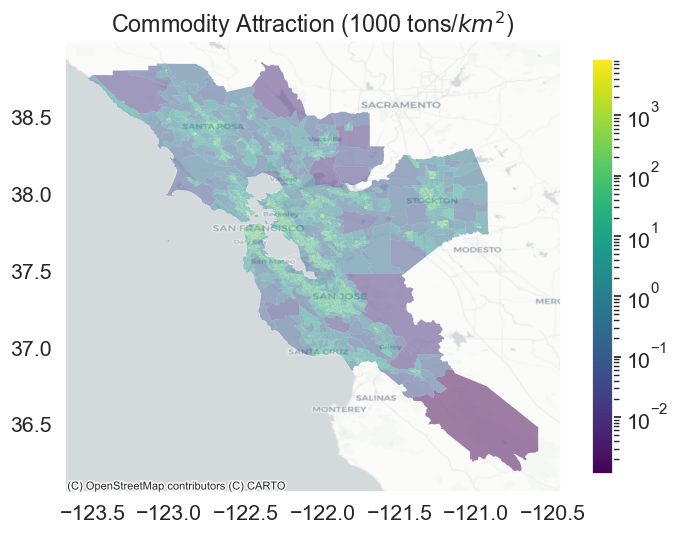

In [28]:
ax = region_map_with_attraction.plot(figsize = (8,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            norm=matplotlib.colors.LogNorm(vmin=region_map_with_attraction.attraction_per_area.min(), 
                                                           vmax=region_map_with_attraction.attraction_per_area.max()),
                                    cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.9})
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Commodity Attraction (1000 tons/$km^{2}$)')
ax.grid(False)
plt.savefig('plots_SF/region_attraction_allmodes.png', dpi = 200)